In [206]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

#This section of code has all of the data import, merging, and initial setup.

test_data_split = 230  #this will be the number of weeks in the test data set, remainder of data in train data set
#Calculate the split date to use
split_date = datetime.now() - timedelta(weeks=test_data_split) 
print('Split Date: {0}'.format(split_date))

#Read in the transportation data, monthly seasonally adjusted
tsi_data = pd.read_excel(".\data\Input_SeasonalData_TSI.xlsx", header=2)

#Read in the real gdp growth rates,seasonally adjusted, quarterly data with quarterly growth rates
gdp_data = pd.read_excel(".\data\Input_GDP_st_louis_fed_quarterly_change.xlsx")

#Merge the 2 datasets together based on the date. 
merged_data = pd.merge(tsi_data, gdp_data, how='left', left_on='OBS_DATE', right_on='observation_date')

#We now have 2 date columns.  Drop the date column from the gdp_data dataframe.
merged_data = merged_data.drop(['observation_date'], axis=1) #pandas can drop rows or columns, axis=1 indicates columns

#Forward fill the gdp data so that a quarterly gdp value will be used for 3 rows, with each row being a month.
#limit it only fill in 2 consective missing values.
merged_data['Real_gdp_qtr_growth'] = merged_data['Real_gdp_qtr_growth'].fillna(method='ffill', limit=2)

#drop rows where we don't have a gdp value
merged_data = merged_data.dropna(subset=['Real_gdp_qtr_growth'])

#Create a boolean column to indicate if gdp growth was positive or negative.
merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: True if x['Real_gdp_qtr_growth'] > 0.0 else False, axis=1)

merged_data['RAIL_FRT_PCT'] = merged_data['RAIL_FRT_CARLOADS_D11'].pct_change()*100.0
merged_data['RAIL_INTERMOD_PCT'] = merged_data['RAIL_FRT_INTERMODAL_D11'].pct_change()*100.0
merged_data['WATERBORNE_PCT'] = merged_data['WATERBORNE_D11'].pct_change()*100.0
merged_data['TRUCK_PCT'] = merged_data['TRUCK_D11'].pct_change()*100.0
merged_data['AIR_RTMFM_PCT'] = merged_data['AIR_RTMFM_D11'].pct_change()*100.0
merged_data['TSI_PCT'] = merged_data['TSI'].pct_change()*100.0

#create x_train and y_train dataframes
x_train = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'RAIL_FRT_PCT':'TSI_PCT']
x_train.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_class = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'gdp_is_increasing'] #ydata for classifier models
y_train_class.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_rate = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'Real_gdp_qtr_growth'] #y data for regression models
y_train_rate.drop([0], inplace=True) #drop first row as it will have NA for pct_change values

print('x_train row count: {0}'.format(len(x_train.index)))
print('y_train_class row count: {0}'.format(len(y_train_class.index)))
print('y_train_rate row count: {0}'.format(len(y_train_rate.index)))

x_test = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'RAIL_FRT_PCT':'TSI_PCT']
y_test_class = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'gdp_is_increasing']
y_test_rate = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'Real_gdp_qtr_growth']

print('x_test row count: {0}'.format(len(x_test.index)))
print('y_test_class row count: {0}'.format(len(y_test_class.index)))
print('y_test_rate row count: {0}'.format(len(y_test_rate.index)))

Split Date: 2015-11-28 20:41:51.083639
x_train row count: 190
y_train_class row count: 190
y_train_rate row count: 190
x_test row count: 49
y_test_class row count: 49
y_test_rate row count: 49


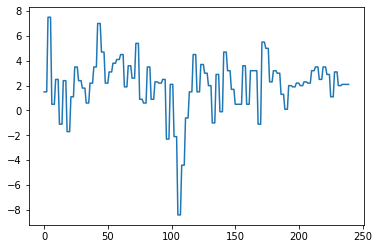

In [324]:
import matplotlib.pyplot as plt

plt.plot(merged_data['Real_gdp_qtr_growth'])

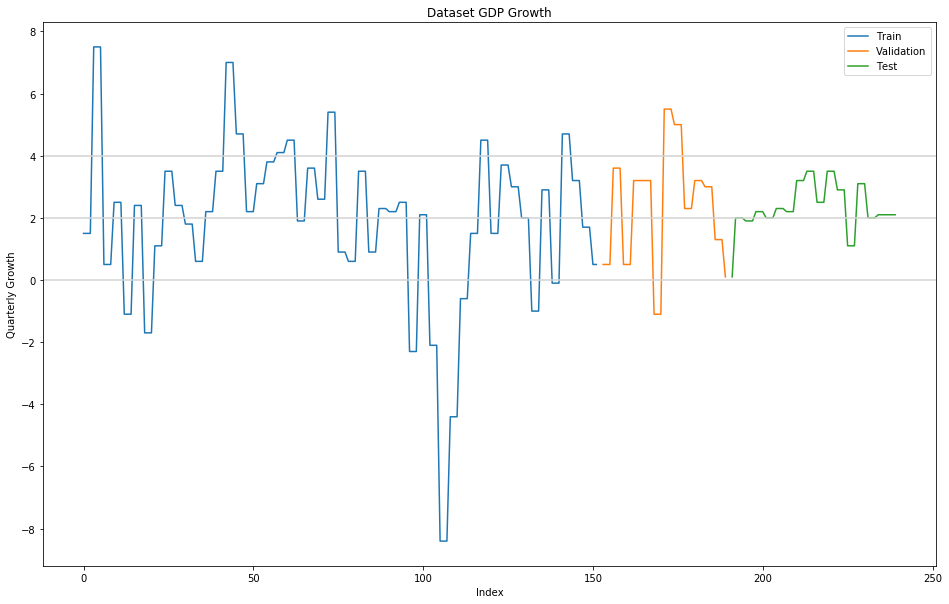

In [345]:
plt.plot(merged_data.iloc[:152]['Real_gdp_qtr_growth'], Label="Train")
plt.plot(merged_data.iloc[153:190]['Real_gdp_qtr_growth'], Label="Validation")
plt.plot(merged_data.iloc[191:]['Real_gdp_qtr_growth'], Label="Test")
plt.title('Dataset GDP Growth')
plt.ylabel('Quarterly Growth')
plt.xlabel('Index')
plt.legend()
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)

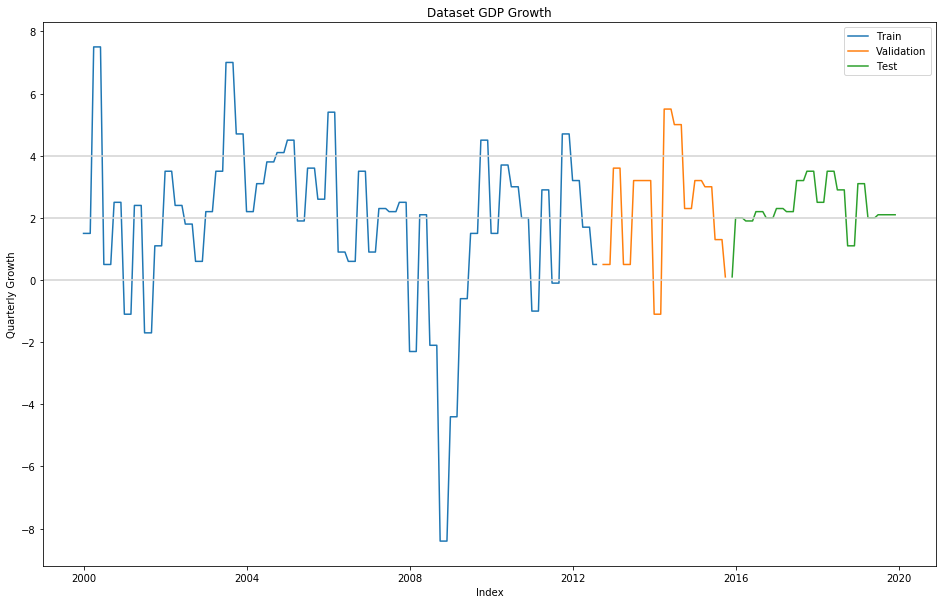

In [354]:
plt.plot(merged_data.iloc[:152]['OBS_DATE'], merged_data.iloc[:152]['Real_gdp_qtr_growth'], Label="Train")
plt.plot(merged_data.iloc[153:190]['OBS_DATE'], merged_data.iloc[153:190]['Real_gdp_qtr_growth'], Label="Validation")
plt.plot(merged_data.iloc[191:]['OBS_DATE'], merged_data.iloc[191:]['Real_gdp_qtr_growth'], Label="Test")
plt.title('Dataset GDP Growth')
plt.ylabel('Quarterly Growth')
plt.xlabel('Index')
#plt.xticks(np.arange(2000, 2020,step=2))
plt.legend()
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)
#merged_data

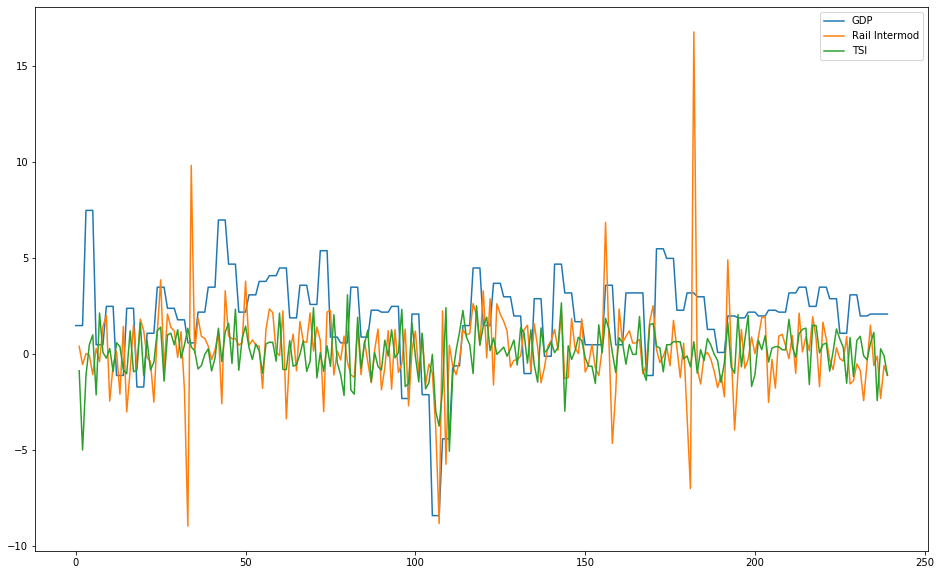

In [208]:
from matplotlib.pyplot import figure
#plt.plot(merged_data['RAIL_FRT_PCT'], label='Rail Frt')
plt.plot(merged_data['Real_gdp_qtr_growth'], label='GDP')
plt.plot(merged_data['RAIL_INTERMOD_PCT'], label='Rail Intermod')
#plt.plot(merged_data['WATERBORNE_PCT'], label='Water')
#plt.plot(merged_data['TRUCK_PCT'], label='Truck')
#plt.plot(merged_data['AIR_RTMFM_PCT'], label='Air and Mail Frt')
plt.plot(merged_data['TSI_PCT'], label='TSI')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16,10)

In [209]:
railcorr = np.corrcoef(x_train['RAIL_FRT_PCT'], y_train_rate)
print('Rail Frt Corr: {0:0.2f}'.format(railcorr[0,1]))

railimodcorr = np.corrcoef(x_train['RAIL_INTERMOD_PCT'], y_train_rate)
print('Rail Intermod Corr: {0:0.2f}'.format(railimodcorr[0,1]))

watercorr = np.corrcoef(x_train['WATERBORNE_PCT'], y_train_rate)
print('Water Corr: {0:0.2f}'.format(watercorr[0,1]))

truckcorr = np.corrcoef(x_train['TRUCK_PCT'], y_train_rate)
print('Truck Corr: {0:0.2f}'.format(truckcorr[0,1]))

aircorr = np.corrcoef(x_train['AIR_RTMFM_PCT'], y_train_rate)
print('Air and Mail Frt Corr: {0:0.2f}'.format(aircorr[0,1]))

tsicorr = np.corrcoef(x_train['TSI_PCT'], y_train_rate)
print('TSI Corr: {0:0.2f}'.format(tsicorr[0,1]))


Rail Frt Corr: 0.13
Rail Intermod Corr: 0.21
Water Corr: 0.02
Truck Corr: 0.18
Air and Mail Frt Corr: 0.19
TSI Corr: 0.23


In [210]:
#railcorr

In [211]:
#x_train['RAIL_FRT_PCT']

In [212]:
#y_train_rate

In [213]:
#merged_data['RAIL_FRT_PCT']

In [214]:
#y_train_rate

In [215]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train_std = x_train - mean
x_train_std = x_train / std

x_test_std = x_test - mean
x_test_std = x_test / std

In [216]:
#x_train_std.shape[1,]
x_trainstdnp = x_train_std.to_numpy()
x_trainstdnp.shape

(190, 6)

In [217]:
x_train_std.shape

(190, 6)

In [307]:
from keras.models import Sequential
from keras.layers import Dense , Lambda #,Dropout ,  Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
#import tensorflow as tf

def get_nn_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(1,)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model        

In [323]:
model=get_nn_model()
model.optimizer.lr=0.05
#history=model.fit(x=x_train_std.iloc[:153]['TSI_PCT'], y=y_train_rate.iloc[:153], epochs=500)#, validation_split=0.2) # shuffle=True) #, batch_size=5)
history=model.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2) # shuffle=True) #, batch_size=5)

Train on 152 samples, validate on 38 samples
Epoch 1/500
152/152 [==============================] - 6s 36ms/step - loss: 9.6692 - mean_absolute_error: 2.4632 - val_loss: 6.7079 - val_mean_absolute_error: 2.1129
Epoch 2/500
152/152 [==============================] - 0s 145us/step - loss: 7.4323 - mean_absolute_error: 2.0479 - val_loss: 3.9324 - val_mean_absolute_error: 1.5332
Epoch 3/500
152/152 [==============================] - 0s 158us/step - loss: 6.9746 - mean_absolute_error: 1.9475 - val_loss: 2.9903 - val_mean_absolute_error: 1.4240
Epoch 4/500
152/152 [==============================] - 0s 164us/step - loss: 6.5095 - mean_absolute_error: 1.8596 - val_loss: 3.3881 - val_mean_absolute_error: 1.5629
Epoch 5/500
152/152 [==============================] - 0s 164us/step - loss: 6.9136 - mean_absolute_error: 1.9033 - val_loss: 3.8013 - val_mean_absolute_error: 1.6597
Epoch 6/500
152/152 [==============================] - 0s 158us/step - loss: 6.3258 - mean_absolute_error: 1.8827 - val_l

152/152 [==============================] - 0s 145us/step - loss: 6.6572 - mean_absolute_error: 1.8861 - val_loss: 3.1914 - val_mean_absolute_error: 1.5211
Epoch 50/500
152/152 [==============================] - 0s 145us/step - loss: 6.3537 - mean_absolute_error: 1.8543 - val_loss: 3.4801 - val_mean_absolute_error: 1.5958
Epoch 51/500
152/152 [==============================] - 0s 132us/step - loss: 6.0651 - mean_absolute_error: 1.8292 - val_loss: 3.2403 - val_mean_absolute_error: 1.5391
Epoch 52/500
152/152 [==============================] - 0s 151us/step - loss: 6.2041 - mean_absolute_error: 1.8487 - val_loss: 3.0670 - val_mean_absolute_error: 1.4885
Epoch 53/500
152/152 [==============================] - 0s 132us/step - loss: 6.1845 - mean_absolute_error: 1.7699 - val_loss: 3.2848 - val_mean_absolute_error: 1.5480
Epoch 54/500
152/152 [==============================] - 0s 125us/step - loss: 6.2031 - mean_absolute_error: 1.8458 - val_loss: 3.7205 - val_mean_absolute_error: 1.6662
Epoch

Epoch 98/500
152/152 [==============================] - 0s 151us/step - loss: 6.3773 - mean_absolute_error: 1.8433 - val_loss: 3.1217 - val_mean_absolute_error: 1.5000
Epoch 99/500
152/152 [==============================] - 0s 151us/step - loss: 6.2899 - mean_absolute_error: 1.8462 - val_loss: 3.2250 - val_mean_absolute_error: 1.5403
Epoch 100/500
152/152 [==============================] - 0s 138us/step - loss: 6.1165 - mean_absolute_error: 1.8350 - val_loss: 3.2083 - val_mean_absolute_error: 1.5395
Epoch 101/500
152/152 [==============================] - 0s 145us/step - loss: 6.4322 - mean_absolute_error: 1.8376 - val_loss: 3.1599 - val_mean_absolute_error: 1.5126
Epoch 102/500
152/152 [==============================] - 0s 132us/step - loss: 6.1997 - mean_absolute_error: 1.7961 - val_loss: 3.1762 - val_mean_absolute_error: 1.5211
Epoch 103/500
152/152 [==============================] - 0s 132us/step - loss: 6.1214 - mean_absolute_error: 1.7912 - val_loss: 3.2880 - val_mean_absolute_er

152/152 [==============================] - 0s 164us/step - loss: 6.0740 - mean_absolute_error: 1.8169 - val_loss: 3.1377 - val_mean_absolute_error: 1.5146
Epoch 147/500
152/152 [==============================] - 0s 197us/step - loss: 6.6394 - mean_absolute_error: 1.8913 - val_loss: 3.1514 - val_mean_absolute_error: 1.5170
Epoch 148/500
152/152 [==============================] - 0s 204us/step - loss: 6.2366 - mean_absolute_error: 1.8329 - val_loss: 3.2858 - val_mean_absolute_error: 1.5471
Epoch 149/500
152/152 [==============================] - 0s 197us/step - loss: 6.1905 - mean_absolute_error: 1.8117 - val_loss: 3.5138 - val_mean_absolute_error: 1.5992
Epoch 150/500
152/152 [==============================] - 0s 191us/step - loss: 6.4704 - mean_absolute_error: 1.8286 - val_loss: 3.7280 - val_mean_absolute_error: 1.6411
Epoch 151/500
152/152 [==============================] - 0s 132us/step - loss: 5.9185 - mean_absolute_error: 1.8126 - val_loss: 3.5699 - val_mean_absolute_error: 1.6091


Epoch 194/500
152/152 [==============================] - 0s 138us/step - loss: 6.0614 - mean_absolute_error: 1.8326 - val_loss: 3.3139 - val_mean_absolute_error: 1.5603
Epoch 195/500
152/152 [==============================] - 0s 132us/step - loss: 6.1698 - mean_absolute_error: 1.8430 - val_loss: 3.2944 - val_mean_absolute_error: 1.5269
Epoch 196/500
152/152 [==============================] - 0s 138us/step - loss: 6.3503 - mean_absolute_error: 1.8807 - val_loss: 3.6202 - val_mean_absolute_error: 1.6442
Epoch 197/500
152/152 [==============================] - 0s 132us/step - loss: 6.3679 - mean_absolute_error: 1.8583 - val_loss: 4.3113 - val_mean_absolute_error: 1.7644
Epoch 198/500
152/152 [==============================] - 0s 138us/step - loss: 6.2648 - mean_absolute_error: 1.8524 - val_loss: 4.4062 - val_mean_absolute_error: 1.7647
Epoch 199/500
152/152 [==============================] - 0s 132us/step - loss: 6.2348 - mean_absolute_error: 1.8445 - val_loss: 4.1025 - val_mean_absolute_

152/152 [==============================] - 0s 145us/step - loss: 5.9645 - mean_absolute_error: 1.7991 - val_loss: 3.2259 - val_mean_absolute_error: 1.5053
Epoch 243/500
152/152 [==============================] - 0s 138us/step - loss: 6.0397 - mean_absolute_error: 1.8180 - val_loss: 3.0768 - val_mean_absolute_error: 1.4679
Epoch 244/500
152/152 [==============================] - 0s 138us/step - loss: 6.5804 - mean_absolute_error: 1.8958 - val_loss: 3.8768 - val_mean_absolute_error: 1.6789
Epoch 245/500
152/152 [==============================] - 0s 118us/step - loss: 6.1200 - mean_absolute_error: 1.8501 - val_loss: 4.9584 - val_mean_absolute_error: 1.8768
Epoch 246/500
152/152 [==============================] - 0s 125us/step - loss: 6.2736 - mean_absolute_error: 1.8584 - val_loss: 5.0539 - val_mean_absolute_error: 1.9037
Epoch 247/500
152/152 [==============================] - 0s 138us/step - loss: 6.3454 - mean_absolute_error: 1.8517 - val_loss: 4.6694 - val_mean_absolute_error: 1.8381


152/152 [==============================] - 0s 151us/step - loss: 6.0036 - mean_absolute_error: 1.7903 - val_loss: 3.4524 - val_mean_absolute_error: 1.4787
Epoch 291/500
152/152 [==============================] - 0s 184us/step - loss: 6.4998 - mean_absolute_error: 1.8391 - val_loss: 3.7403 - val_mean_absolute_error: 1.5077
Epoch 292/500
152/152 [==============================] - 0s 164us/step - loss: 6.1058 - mean_absolute_error: 1.8115 - val_loss: 3.6716 - val_mean_absolute_error: 1.5110
Epoch 293/500
152/152 [==============================] - 0s 171us/step - loss: 6.5185 - mean_absolute_error: 1.8787 - val_loss: 3.5290 - val_mean_absolute_error: 1.5235
Epoch 294/500
152/152 [==============================] - 0s 164us/step - loss: 6.1274 - mean_absolute_error: 1.8508 - val_loss: 3.6454 - val_mean_absolute_error: 1.5227
Epoch 295/500
152/152 [==============================] - 0s 171us/step - loss: 6.3863 - mean_absolute_error: 1.8794 - val_loss: 4.0256 - val_mean_absolute_error: 1.5489


152/152 [==============================] - 0s 145us/step - loss: 6.1933 - mean_absolute_error: 1.8445 - val_loss: 3.1308 - val_mean_absolute_error: 1.4814
Epoch 339/500
152/152 [==============================] - 0s 151us/step - loss: 6.2040 - mean_absolute_error: 1.8568 - val_loss: 3.1499 - val_mean_absolute_error: 1.4762
Epoch 340/500
152/152 [==============================] - 0s 132us/step - loss: 6.3282 - mean_absolute_error: 1.8669 - val_loss: 3.1630 - val_mean_absolute_error: 1.4798
Epoch 341/500
152/152 [==============================] - 0s 132us/step - loss: 6.1668 - mean_absolute_error: 1.8315 - val_loss: 3.1731 - val_mean_absolute_error: 1.4888
Epoch 342/500
152/152 [==============================] - 0s 138us/step - loss: 6.1902 - mean_absolute_error: 1.8568 - val_loss: 3.1551 - val_mean_absolute_error: 1.4901
Epoch 343/500
152/152 [==============================] - 0s 145us/step - loss: 6.3102 - mean_absolute_error: 1.8599 - val_loss: 3.1540 - val_mean_absolute_error: 1.4935


152/152 [==============================] - 0s 164us/step - loss: 5.7978 - mean_absolute_error: 1.7812 - val_loss: 3.2043 - val_mean_absolute_error: 1.4688
Epoch 387/500
152/152 [==============================] - 0s 151us/step - loss: 6.3114 - mean_absolute_error: 1.8494 - val_loss: 3.1956 - val_mean_absolute_error: 1.4599
Epoch 388/500
152/152 [==============================] - 0s 138us/step - loss: 6.0624 - mean_absolute_error: 1.8394 - val_loss: 3.1863 - val_mean_absolute_error: 1.4763
Epoch 389/500
152/152 [==============================] - 0s 125us/step - loss: 6.4650 - mean_absolute_error: 1.8666 - val_loss: 3.1557 - val_mean_absolute_error: 1.4798
Epoch 390/500
152/152 [==============================] - 0s 151us/step - loss: 6.1910 - mean_absolute_error: 1.8465 - val_loss: 3.1544 - val_mean_absolute_error: 1.4837
Epoch 391/500
152/152 [==============================] - 0s 138us/step - loss: 6.2360 - mean_absolute_error: 1.8463 - val_loss: 3.1521 - val_mean_absolute_error: 1.4883


152/152 [==============================] - 0s 158us/step - loss: 5.9674 - mean_absolute_error: 1.8347 - val_loss: 3.3208 - val_mean_absolute_error: 1.4842
Epoch 435/500
152/152 [==============================] - 0s 171us/step - loss: 6.4802 - mean_absolute_error: 1.8911 - val_loss: 3.2719 - val_mean_absolute_error: 1.5040
Epoch 436/500
152/152 [==============================] - 0s 151us/step - loss: 6.2188 - mean_absolute_error: 1.8566 - val_loss: 3.2468 - val_mean_absolute_error: 1.5196
Epoch 437/500
152/152 [==============================] - 0s 171us/step - loss: 6.1347 - mean_absolute_error: 1.8352 - val_loss: 3.2675 - val_mean_absolute_error: 1.5486
Epoch 438/500
152/152 [==============================] - 0s 145us/step - loss: 6.2723 - mean_absolute_error: 1.8479 - val_loss: 3.2620 - val_mean_absolute_error: 1.5478
Epoch 439/500
152/152 [==============================] - 0s 158us/step - loss: 6.2671 - mean_absolute_error: 1.8537 - val_loss: 3.2897 - val_mean_absolute_error: 1.5438


Epoch 482/500
152/152 [==============================] - 0s 151us/step - loss: 6.1660 - mean_absolute_error: 1.8632 - val_loss: 3.1810 - val_mean_absolute_error: 1.5285
Epoch 483/500
152/152 [==============================] - 0s 138us/step - loss: 6.4254 - mean_absolute_error: 1.8646 - val_loss: 3.2318 - val_mean_absolute_error: 1.5441
Epoch 484/500
152/152 [==============================] - 0s 138us/step - loss: 6.3526 - mean_absolute_error: 1.8577 - val_loss: 3.1297 - val_mean_absolute_error: 1.5148
Epoch 485/500
152/152 [==============================] - 0s 132us/step - loss: 6.6843 - mean_absolute_error: 1.9416 - val_loss: 3.2142 - val_mean_absolute_error: 1.5211
Epoch 486/500
152/152 [==============================] - 0s 138us/step - loss: 6.1988 - mean_absolute_error: 1.8549 - val_loss: 3.1824 - val_mean_absolute_error: 1.5089
Epoch 487/500
152/152 [==============================] - 0s 151us/step - loss: 5.9685 - mean_absolute_error: 1.8243 - val_loss: 3.1614 - val_mean_absolute_

In [316]:
x_train_std.iloc[:152]['TSI_PCT']

1     -0.679199
2     -3.958088
3     -0.881178
4      0.405027
5      0.805946
         ...   
148    0.710154
149    0.563091
150   -0.139782
151   -0.490100
152   -0.493141
Name: TSI_PCT, Length: 152, dtype: float64

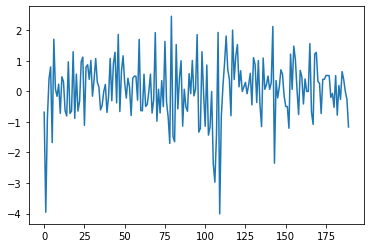

In [290]:
#x_train
plt.plot(x_train_std['TSI_PCT'].to_numpy(), Label="x_train")

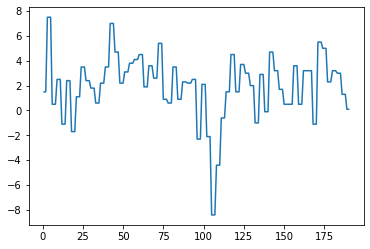

In [291]:
plt.plot(y_train_rate, Label="y_train_rate")

In [292]:
predictions_test = model.predict(x_test_std['TSI_PCT'])

In [293]:
predictions_test.transpose()

array([[ 2.6813407,  1.9163334,  2.7667613,  2.628525 ,  1.8722866,
         2.7658157,  2.0143025,  1.8769382,  1.212484 ,  2.4910362,
         2.0143025,  2.596043 ,  1.9892688,  2.677089 ,  2.9981315,
         3.4036694,  3.3954525,  2.572207 ,  2.5692916,  1.8989036,
         3.3412762,  2.5435784,  1.97703  ,  1.9538066,  1.9475448,
         1.4191649,  1.9310718,  1.9334905,  2.41193  ,  3.0431972,
         2.625344 ,  2.8430636,  2.369745 ,  1.9521229,  2.0078115,
         3.1893833,  1.5564042,  1.9997816,  2.2809463,  2.0149999,
         1.9924963,  2.495641 ,  2.6174502,  2.6878715,  1.9708412,
        -0.3068028,  2.8342354,  2.49597  ,  2.4218023]], dtype=float32)

In [295]:
y_test_rate.to_numpy()

array([0.1, 2. , 2. , 2. , 1.9, 1.9, 1.9, 2.2, 2.2, 2.2, 2. , 2. , 2. ,
       2.3, 2.3, 2.3, 2.2, 2.2, 2.2, 3.2, 3.2, 3.2, 3.5, 3.5, 3.5, 2.5,
       2.5, 2.5, 3.5, 3.5, 3.5, 2.9, 2.9, 2.9, 1.1, 1.1, 1.1, 3.1, 3.1,
       3.1, 2. , 2. , 2. , 2.1, 2.1, 2.1, 2.1, 2.1, 2.1])

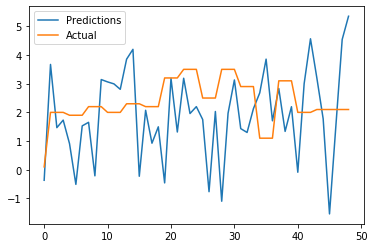

In [296]:
plt.plot(predictions, label='Predictions')
plt.plot(y_test_rate.index - 191, y_test_rate, label='Actual') #the dataframe has its index from the data split
plt.legend()

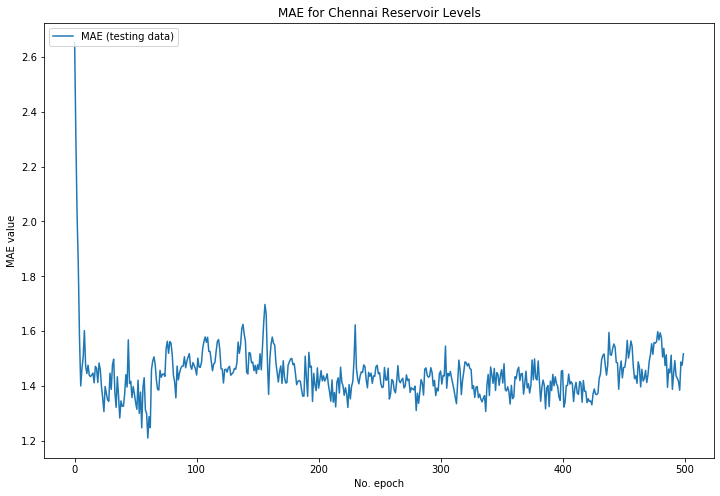

In [321]:
# Plot history: MAE
plt.plot(history.history['mean_absolute_error'], label='MAE (testing data)')
#plt.plot(history.history['val_mean_absolute_error'], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

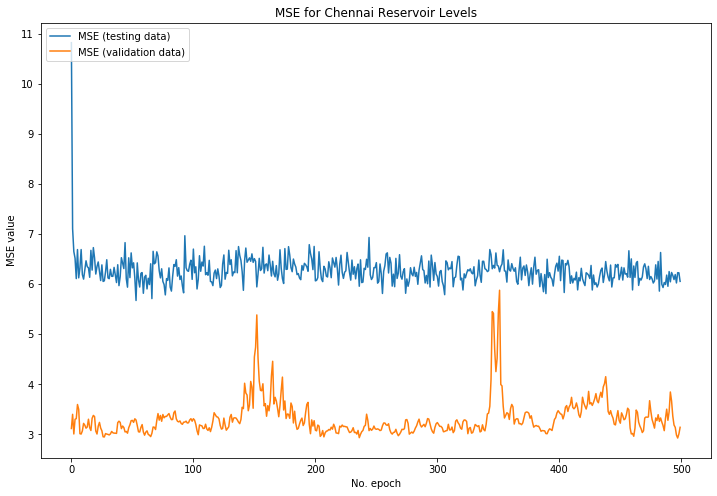

In [288]:
# Plot history: MSE
plt.plot(history.history['loss'], label='MSE (testing data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [246]:
history.history

{'val_loss': [6.529234861072741,
  8.836159128891794,
  6.741439430337203,
  6.446070533049734,
  4.853218567998786,
  6.015131517460472,
  8.27720256228196,
  6.052151027478669,
  5.5102940107646745,
  7.703581358257093,
  8.405340947602925,
  6.354785567835758,
  6.229768803245143,
  7.303603752663261,
  5.53136144186321,
  8.95933395310452,
  7.382559104969627,
  9.62284743158441,
  8.44639838369269,
  10.598456282364694,
  18.11092334044607,
  14.245108353464227,
  12.511284476832339,
  12.364448346589741,
  10.463414945100483,
  15.282452457829526,
  12.304550999089292,
  12.355241988834582,
  8.761192045713726,
  15.300098808188187,
  9.717604561855918,
  9.270263822455155,
  8.864192837163023,
  8.76040116109346,
  7.512536224566008,
  7.321603009575291,
  10.219774974019904,
  6.977180581343801,
  7.658183976223595,
  8.531938339534559,
  7.0604197853489925,
  8.634958543275532,
  10.680370343358893,
  6.134329595063862,
  6.786074387399774,
  14.596788895757575,
  6.6512454936

In [223]:
y_train_rate.to_numpy()

array([ 1.5,  1.5,  7.5,  7.5,  7.5,  0.5,  0.5,  0.5,  2.5,  2.5,  2.5,
       -1.1, -1.1, -1.1,  2.4,  2.4,  2.4, -1.7, -1.7, -1.7,  1.1,  1.1,
        1.1,  3.5,  3.5,  3.5,  2.4,  2.4,  2.4,  1.8,  1.8,  1.8,  0.6,
        0.6,  0.6,  2.2,  2.2,  2.2,  3.5,  3.5,  3.5,  7. ,  7. ,  7. ,
        4.7,  4.7,  4.7,  2.2,  2.2,  2.2,  3.1,  3.1,  3.1,  3.8,  3.8,
        3.8,  4.1,  4.1,  4.1,  4.5,  4.5,  4.5,  1.9,  1.9,  1.9,  3.6,
        3.6,  3.6,  2.6,  2.6,  2.6,  5.4,  5.4,  5.4,  0.9,  0.9,  0.9,
        0.6,  0.6,  0.6,  3.5,  3.5,  3.5,  0.9,  0.9,  0.9,  2.3,  2.3,
        2.3,  2.2,  2.2,  2.2,  2.5,  2.5,  2.5, -2.3, -2.3, -2.3,  2.1,
        2.1,  2.1, -2.1, -2.1, -2.1, -8.4, -8.4, -8.4, -4.4, -4.4, -4.4,
       -0.6, -0.6, -0.6,  1.5,  1.5,  1.5,  4.5,  4.5,  4.5,  1.5,  1.5,
        1.5,  3.7,  3.7,  3.7,  3. ,  3. ,  3. ,  2. ,  2. ,  2. , -1. ,
       -1. , -1. ,  2.9,  2.9,  2.9, -0.1, -0.1, -0.1,  4.7,  4.7,  4.7,
        3.2,  3.2,  3.2,  1.7,  1.7,  1.7,  0.5,  0